**Utility functions related to cost function minimizations**

The main function defined here to be heavily used elsewhere is **bbox_hessian_keyword_minimization()**.

Important functions needed to work with bbox_hessian_keyword_minimization() and also defined here are

* **ForwarDiffZeros()**.  If you're going to declare vectors or matrices inside a function that you want to take derivatives of, *do not* use zeros(). Use ForwardDiffZeros() instead. If you dont' declare vectors or matrices, you won't need it. Be careful. Failing to use ForwardDiffZeros() does not produce an error: your derivatives and hessians simply come back as zeros, and if you don't think of this issue, the reason can feel very mysterious.

* **make_dict()**. If you're working with keyword-value pairs, you will want to manipulate sets of those. make_dict() is a function that helps you do that, for example, for merging current selected parameter values with a superset of default values (see below).  In addition, make_dict() is central to the gradient- and hessian-taking functions defined here that operate on keyword-value pairs. The reason is that make_dict() can take a vector (as one of its parameters)and turn it into keyword-value pairs, and we need this transformation to work with the ForwardDiff package, since that package only operates on functions of vectors.

Two other functions often used are **vgh()** (a wrapper to fund the value, gradient, and hessian of a scalar function of a vector) and **keyword_vgh()** (a wrapper like vgh() except it operates on functions that take only keyword-value pairs).


<h1 id="tocheading">TABLE OF CONTENTS</h1>
<div id="toc"></div>

**Updates to the table of contents are periodic, but run the cell below to first start or force an update.**

In [1]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
$.getScript('make_table_of_contents.js')
"""

# make_dict() and ForwardDiffZeros()

The ForwardDiff package takes gradients of functions of vectors. `make_dict()` was originally written as an internal function to keyword_vgh(), essentially for turning keyword-value pairs into a vector that ForwardDiff could work with. The main goal was to make gradient-taking flexible, so the user could easily switch between different chosen parameters. However, make_dict() turns out to be useful externally, for the user, also.

The basic usage of make_dict is to take a list of strings, and a vector of numeric values of the same length, and turn those into a dictionary that Julia can use when passing paramaters. Thus, for example,

> `tester(;a=10, b=20)`

is equivalent to


> `tester(;make_dict(["a", "b"], [10, 20])...)`

which can be used to pass all the various desired parameter values as a single vector, which is what ForwardDiff needs, and is how keyword_vgh() works.

> (**An aside on Julia symbols and passing sets of keyword-values to functions**: The `...` is Julia-speak for "this argument contains a set of multiple keyword-value pairs."  In Julia, that can be either a dictionary of Symbol=>value pairs, or a list of (Symbol, value) tuples). 

> `make_dict()` itself returns a dictionary, so `make_dict(["a", "b"], [10, 20])` returns `Dict(:a=>10, :b=>20)`.  A Julia Symbol stands for a variable; you can go back and forth between strings and Symbols by using, for example, `Symbol("a")` to get `:a`, or use `string(:a)` to get `"a"`.)


## Typical user-level usage of make_dict()

The typical thing a user will use make_dict() for is to merge paramater values with a superset of default parameter values. For example, suppose you have defined a scalar function

> `function tester(;a=1, b=2, c=3, d=4)`

You can decide you want your default parameter values to be as defined here:

> `defaults = Dict(:a=>10, :b=20, :c=>30, :d=>40)`

Given that, you can call `tester()` with this set of values by calling `tester(;defaults...)`.


Now suppose you've done a minimization search over two of these paramaters. Let's say that you indicate your choice of those parameters in `args = ["a", "c"]`. And let's say the resulting values for them are in the two-long vector `pars`.  You want to call `tester()` with the default parameter values _except_ for whatever is indicated in `args` and `pars`. To do that, you use the optional third argument of `make_dict()` as follows:

> `tester(;make_dict(args, pars, defaults)...)`


See the examples below

In [2]:
#@include_me hessian_utils.jl

include("constrained_parabolic_minimization.jl")

"""
dict = make_dict(argstrings, x, [starting_dict=Dict()] )

Given a list of strings, and a list of values, makes a dictionary of Symbols to values, with the Symbols 
corresponding to each of the strings.  Mostly used to pass arguments as a keyword-value set into a function.
If one of the elements of argstrings is *not* a string, but is instead a 2-long list, the first element of that 
list should be a string, and the second element of that list should be a positive integer. This will be 
interpreted as "don't take only one value, take this number of values and this parameter will be a vector"

# PARAMS:

* argstrings     A list of strings. Each element may also be a two-long list of a string, positive integer, e.g., ["this" 3]

* x              A vector of numeric values. Its length must be such that all the strings in argstrings
                 can take their corresponding element(s), sequentially, from x

* starting_dict  An optional initial dictionary to work with.  Any key in this starting dictionary matching an argstring
                 will be replaced by the new value. Keys not matched will remain.

# RETURNS:

dict             The symbol dictionary.


# EXAMPLES:

>> make_dict(["this", "that", ["there", 2]], [10, 20, 3, 4])

Dict{Any,Any} with 3 entries:
  :this  => 10
  :that  => 20
  :there => [3,4]

>> make_dict(["doo", "gaa"], [10, 20], Dict(:blob=>100, :gaa=>-44))

Dict{Symbol,Int64} with 3 entries:
  :gaa  => 20
  :blob => 100
  :doo  => 10

"""
function make_dict(args, x, starting_dict=Dict())
    # For error diagnostics, check that the length of the param vector specified in args matches the length of x
    nargs = 0
    for i in [1:length(args);]
        if typeof(args[i])==String # if the entry in args is a string, then there's one corresponding scalar entry in x0
            nargs += 1
        else
            nargs += args[i][2]    # otherwise, the entry in args should be a  [varnamestring, nvals] vector, 
            # indicating that the next nvals entries in x0 are all a single vector, belonging to variable
            # with name varnamestring. 
        end
    end
    if nargs != length(x)
        error("Oy! args and x must indicate the same total number of variables!")
    end

    
    # ---- done error-checking, now main function
    
    kwargs = starting_dict;
    i = 1; j=1
    while i<=length(args)
        if typeof(args[i])==String
            kwargs = merge(kwargs, Dict(Symbol(args[i]) => x[j]))
        else
            if length(args[i]) == 2
                extra = args[i][2]-1
                kwargs = merge(kwargs, Dict(Symbol(args[i][1]) => x[j:(j+extra)]))
                j = j+extra
            else
                error("Each element of the args vector must be either a string, or a 2-long vector, first element a string, second integer")
            end            
        end
        i = i+1; j=j+1
    end
    return kwargs
end 


using ForwardDiff


# Here we're going to define a closure over x so that when this code runs, it sets the local variable
# x to report ForwardDiff's verison number; then we export the function FDversion, that simply returns
# x.  When we call FDversion(), it simply returns the value of x, stored locally inside the let block.
# So it is extremely fast.
let x 
    try
        x = Pkg.installed("ForwardDiff").major + 0.1*Pkg.installed("ForwardDiff").minor
    catch
        error("Is ForwardDiff really installed???")
    end

    global FDversion

    @doc """
    v = FDversion()

    Return the installed version of ForwardDiff as a floating point, major.minor
    """ function FDversion()
        return x
    end
end


if FDversion() < 0.6
    # --------------------------------------------------------------
    #
    #               FOR FORWARDDIFF < 0.6   (Julia 0.5.2)
    #
    # --------------------------------------------------------------
    
    
    # """
    # We define functions to convert Duals, the variable types used by ForwardDiff, 
    # to Floats. This is useful if we want to print out the value of a variable 
    # (since print doesn't know how to Duals). Note that after being converted to a Float, no
    # differentiation by ForwardDiff can happen!  e.g. after
    #     x = convert(Float64, y)
    # ForwardDiff can still differentiate y, but it can't differentiate x
    # """

    import Base.convert
    convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
    function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
        y = zeros(size(x)); 
        for i in 1:prod(size(x)) 
            y[i] = convert(Float64, x[i]) 
        end
        return y
    end
    
    

    """
    function M = ForwardDiffZeros(m, n; nderivs=0, difforder=0)

    Use instead of zeros(). Creates a matrix of zeros, of size m rows by n columns, with elements appropriate for 
    differentiation by ForwardDiff. If nderivs==0 or difforder==0 then the elements will be regular
    Float64, not ForwardDiff types.

    PARAMETERS:
    ===========

    m        Integer, number of rows

    n        Integer, number of columns


    OPTIONAL PARAMETERS:
    ====================

    nderivs=0       The number of variables that we'll be differentiating with respect to. In other
                    words, this number is equal to the length of the gradient. If this is left as zero (the default) then 
                    the data type will be regular Float64

    difforder=0     The order of the derivative we will want to take.  Zero means nothing, stick with
                    regular Float64, 1 means gradient, 2 means hessian

    RETURNS:
    ========

    An m-by-n matrix of zeros that can be used with Forward Diff.

    """
    function ForwardDiffZeros(m, n; nderivs=0, difforder=0)
        if nderivs == 0 || difforder == 0
            return zeros(m, n)
        elseif difforder == 1
            return zeros(ForwardDiff.Dual{nderivs, Float64}, m , n)
        elseif difforder == 2
            return zeros(ForwardDiff.Dual{nderivs, ForwardDiff.Dual{nderivs, Float64}}, m, n)
        else
            error("Don't know how to do that order of derivatives!", nderivs)
        end
    end
          
else
    
    # --------------------------------------------------------------
    #
    #         FOR FORWARDDIFF >= 0.6   (Julia 0.6 and onwards)
    #
    # --------------------------------------------------------------
    
    
    @doc """
    e = get_eltype(vars)
    
    vars should be a tuple of variables. If any of them is a ForwardDiff Dual, this function returns
    the typeof of that one (the first one encountered); otherwise it returns Float64.
    """ function get_eltype(vars)
        # print("vars is "); print(vars); print("\n")
        # print("typeof(vars) is "); print(typeof(vars)); print("\n")
        if ! (typeof(vars)<:Tuple)
            error("vars must be a Tuple (of variables)")
        end
        for v in vars
            # print("About to check v = "); print(v); print("\n")
            # If it's an array, check its elements
            if typeof(v)<:Array && length(v)> 0 && typeof(v[1])<:ForwardDiff.Dual
                return typeof(v[1])
            end
            # If it's an array of tuples, check each one
            if typeof(v)<:Array && length(v)> 0 && typeof(v[1])<:Tuple
                for tup in v; if typeof(tup[2])<:ForwardDiff.Dual; return typeof(tup[2]); end; end
            end
            # If it's a Pair, check its value
            if typeof(v)<:Pair && typeof(v[2])<:ForwardDiff.Dual
                return typeof(v[2])
            end
            # If it's a tuple, try to turn it into a Dict
            if typeof(v)<:Tuple 
                try; myv = Dict(v); catch; error("Sorry don''t know how to deal with that kind of Tuple"); end
            else
                myv = v
            end
            # If it's a Dict, check all the key contents
            if typeof(myv)<:Dict
                for k in keys(myv)
                    # print("about to check key "); print(k); print(" with value "); print(myv[k]); print("\n")
                    if get_eltype(Tuple(myv[k]))<:ForwardDiff.Dual
                        return get_eltype(Tuple(myv[k]))
                    end
                end
            end
            if typeof(myv)<:ForwardDiff.Dual
                return typeof(myv)
            end
        end
        return Float64
    end


end


# We're deprecating automatic converts from Dual to Float64; 
# instead, let's use an explicit call to a get_value function.
# That means that any accidental casts into Float64s will cause errors, alerting us of 
# problems rather than letting the code run but producing derivatives that are zero
    
    
@doc """
v = get_value(x)
    
If you're going to @print something that might be a ForwardDiff Dual, use this function. It'll
return the value of the number if it is a Dual and just the number if it was not a Dual, suitable for
printing, e.g.
    
    @printf("%g\n", get_value(x))
    
will work regardless of whether x is a ForwardDiff Dual, a Float64, or an Int64    
""" function get_value(x)
    if typeof(x)<:Array && length(x)>0 
        if typeof(x[1])<:ForwardDiff.Dual
            y = zeros(size(x)); 
            if typeof(x[1].value)<:ForwardDiff.Dual  # nested, taking 2nd derivative
                for i=1:length(y); y[i] = x[i].value.value; end;
            else # not nested, 1st derivative
                for i=1:length(y); y[i] = x[i].value; end;
            end
            return y
        elseif typeof(x[1])<:Int64 || typeof(x[1])<:Float64
            return x
        else
            error(@sprintf("Don't know how to get the value of type %s", typeof(x[1])))
        end
    elseif typeof(x)<:Array
        return zeros(size(x))
    elseif typeof(x)<:ForwardDiff.Dual
        if typeof(x.value)<:ForwardDiff.Dual; return x.value.value; else; return x.value; end;
    elseif typeof(x)<:Int64 || typeof(x)<:Float64
        return x
    else
        error(@sprintf("Don't know how to get the value of type %s", typeof(x)))
    end
end    


get_value

### In ForwardDiff 0.6: example of using get_eltype()

In [3]:
a = [100, 200]
b = 34.5
c = Dict(:gu=>ForwardDiff.Dual{Float64}(1,0))
get_eltype((a,b,c))

ForwardDiff.Dual{Float64,Int64,1}

### In ForwardDiff 0.6: Example of using get_value() and get_eltype()

In [4]:
# This one uses vgh(), so you can only run it after declaring vgh() belos
# 
# if FDversion() >= 0.6
# 
#     tt = Array{Any}(1,2)
# 
#     function tester(x, tt)
#        y = zeros(get_eltype(x[1]), size(x))
#        for i=1:length(x), y[i] = x[i]; end;
#    
#        tt[1] = y
#        return sum(y).^4
#     end
#
#     value, grad, hess = vgh(x -> tester(x, tt), [1.1, 2.2])
#
# end

In [5]:
# if FDversion() >= 0.6
# 
#    print(get_value(tt[1]))
#    get_eltype(tt[1])
# end


### Example of using make_dict()

In [6]:
include("general_utils.jl")   # just for getting things like print_vector_g() for our examples

vectorize_dict

In [7]:
function tester(;a=1, b=2, c=3, d=4)
    @printf("a=%g\n", a)
    @printf("b=%g\n", b)
    @printf("c=%g\n", c)
    @printf("d=%g\n", d)
end

defaults = Dict(:a=>10, :b=>20, :c=>30, :d=>40)

@printf("tester():\n")
tester()
@printf("\n")

@printf("tester(;defaults...):\n")
tester(;defaults...)
@printf("\n")

@printf("make_dict([\"a\", \"c\"], [-5, -6]):\n")
print(make_dict(["a", "c"], [-5, -6]))
@printf("\n\n")

@printf("tester(;make_dict([\"a\", \"c\"], [-5, -6])...) changes a and c but doesn't use what is in defaults:\n")
tester(;make_dict(["a", "c"], [-5, -6])...)
@printf("\n")

@printf("tester(;make_dict([\"a\", \"c\"], [-5, -6], defaults)...) changes a and c and *does* use what is in defaults:\n")
tester(;make_dict(["a", "c"], [-5, -6], defaults)...)
@printf("\n")


tester():
a=1
b=2
c=3
d=4

tester(;defaults...):
a=10
b=20
c=30
d=40

make_dict(["a", "c"], [-5, -6]):
Dict{Any,Any}(Pair{Any,Any}(:a, -5),Pair{Any,Any}(:c, -6))

tester(;make_dict(["a", "c"], [-5, -6])...) changes a and c but doesn't use what is in defaults:
a=-5
b=2
c=-6
d=4

tester(;make_dict(["a", "c"], [-5, -6], defaults)...) changes a and c and *does* use what is in defaults:
a=-5
b=20
c=-6
d=40



### Example of how to declare an array within a function, and then differentiate

In [8]:
if FDversion() < 0.6
    # --------------------------------------------------------------
    #
    #         FOR FORWARDDIFF < 0.6   (Julia 0.5.2)
    #
    # --------------------------------------------------------------

    function tester(; a=1, b=2, c=3, nderivs=0, difforder=0)
        # we declare a matrix; when declaring it, we want to make sure that it is a ForwardDiff Dual if we
        # are going to assign it variables that we will differentiate, otherwise we can't do the assignment.
        #
        # This would cause an error if we try to differentiate:
        # y = zeros(1, 3)  
        # 
        # So instead we do this:
        y = ForwardDiffZeros(1, 3, nderivs=nderivs, difforder=difforder)

        y[1] = a
        y[2] = b
        y[3] = c

        return y[1]^3 + y[2]^2 + sqrt(y[3])
    end
    
    
else

    # --------------------------------------------------------------
    #
    #         FOR FORWARDDIFF >= 0.6   (Julia 0.6 and onwards)
    #
    # --------------------------------------------------------------

    function tester(; a=1, b=2, c=3)
        # we declare a matrix; when declaring it, we want to make sure that it is a ForwardDiff Dual if we
        # are going to assign it variables that we will differentiate, otherwise we can't do the assignment.
        #
        # This would cause an error if we try to differentiate:
        # y = zeros(1, 3)  
        # 
        # So instead we do this:
        y = zeros(get_eltype((a,b,c)), 1, 3)
        # Notice the call to get_eltype-- we don't know whether we'll be differentiating w.r.t. a, b, or c,
        # so get_eltype will check them all (and return Float64 if no differentiation is happening)

        y[1] = a
        y[2] = b
        y[3] = c

        return y[1]^3 + y[2]^2 + sqrt(y[3])
    end
        
end


# Now we can do our differentiation
args = ["a", "c"]; 
pars = [3.1, 1.1]; 
if FDversion() < 0.6
    func = x -> tester(;nderivs=length(x), difforder=1, make_dict(args, x)...)

    grad = ForwardDiff.gradient(func, pars)
else
    func = x -> tester(;make_dict(args, x)...)
end

grad = ForwardDiff.gradient(func, pars)
@printf("This is the gradient: "); print_vector_g(grad); print("\n")

if FDversion() < 0.6
    func = x -> tester(;nderivs=length(x), difforder=2, make_dict(args, x)...)
end
hess = ForwardDiff.hessian(func, pars)
@printf("This is the hessian[:] : "); print_vector_g(hess[:]); print("\n")


This is the gradient: [28.83, 0.476731]
This is the hessian[:] : [18.6, 0, 0, -0.216696]


# keyword_vgh()  [vgh() is now in Constrained Parabolic Minimization.ipynb]

In [9]:
#@include_me hessian_utils.jl

using ForwardDiff

if FDversion() < 0.6
    # --------------------------------------------------------------
    #
    #               FOR FORWARDDIFF < 0.6   (Julia 0.5.2)
    #
    # --------------------------------------------------------------



    """
    function value, gradient, hessian = keyword_vgh(func, args, x0)

    Wrapper for vgh() that computes and returns all three of a function's value, gradient, and hessian, but now
    uses make_dict() to apply it to a function that only takes keyword-value pairs. 

    *Note that func MUST also take the keyword parameters nderivs and difforder*. If you declare any vectors or 
    matrices inside func() (or inside any function inside func()), use ForwardDiffZeros with these two parameters, 
    do NOT use zeros(). Your gradients will come out as zero is you use zeros().

    # PARAMETERS

    * func    A function that takes keyword-value pairs only, including nderivs and difforder.  I.e., it must be a function declared as `function func(; nderivs=0, difforder=0, other_kw_value_pairs)` or as `function func(; nderivs=0, difforder=0, other_kw_value_pairs_dict...)`
    * args    A list of strings indicating names of variables to work with
    * x0      A vector with the value of the variables indicates in args.  **See make_dict() for how to pass both scalars and vectors as variables**

    # IMPORTANT JULIA BUG

    If you modify func, it is possible that keyword_vgh() will still work on the previously defined version. AACK!  
    That's horrible! Alice Yoon's tip on the workaround: instead of func(), use (;params...) -> func(; params...) and then
    everything will be fine. Perhaps this bug will be fixed in Julia 0.6

    # EXAMPLE:

    function tester(;a=10, b=20, c=30, nderivs=0, difforder=0)
        M = ForwardDiffZeros(3, 3; nderivs=nderivs, difforder=difforder)
        M[1,1] = a^2*10
        M[2,2] = b*20
        M[3,3] = a*sqrt(c)*30.1
        return trace(M)
    end

    value, grad, hess = keyword_vgh(tester, ["a", "c"], [10, 3.1])

    value, grad, hess = keyword_vgh((;params...) -> tester(;params...), ["a", "c"], [10, 3.1])

    """
    function keyword_vgh(func, args, x0)

        value, gradient, hessian = vgh(x -> func(;nderivs=length(x), difforder=2, make_dict(args, x)...), x0)

        return value, gradient, hessian    
    end
    
    
else    
    # --------------------------------------------------------------
    #
    #         FOR FORWARDDIFF >= 0.6   (Julia 0.6 and onwards)
    #
    # --------------------------------------------------------------


    """
    function value, gradient, hessian = keyword_vgh(func, args, x0)

    Wrapper for vgh() that computes and returns all three of a function's value, gradient, and hessian, but now
    uses make_dict() to apply it to a function that only takes keyword-value pairs. 

    *Note that if you declare any vectors or matrices inside func() (or inside any function inside func()), 
    you will need to make sure they are ForwardDiff Duals if you want to differentiate w.r.t. their contents.*
    The function get_eltype()  can help you with this.  For example, if you have three variables, a, b, and c,
    and you don't know in advance which one you will differentiate w.r.t., you could declare a matrix using
    
        new_matrix = zeros(get_eltype((a,b,c)), 2, 3)
    
    and that will make sure that it is the right type if you later want derivatives of contents of that 
    matrix.

    # PARAMETERS

    * func    A function that takes keyword-value pairs only, including nderivs and difforder.  I.e., it must be a function declared as `function func(; nderivs=0, difforder=0, other_kw_value_pairs)` or as `function func(; nderivs=0, difforder=0, other_kw_value_pairs_dict...)`
    * args    A list of strings indicating names of variables to work with
    * x0      A vector with the value of the variables indicates in args.  **See make_dict() for how to pass both scalars and vectors as variables**

    # IMPORTANT JULIA BUG

    If you modify func, it is possible that keyword_vgh() will still work on the previously defined version. AACK!  
    That's horrible! Alice Yoon's tip on the workaround: instead of func(), use (;params...) -> func(; params...) and then
    everything will be fine. Not sure yet whether this bug is fixed in Julia 0.6

    # EXAMPLE:

    function tester(;a=10, b=20, c=30)
        M = zeros(get_eltype((a,b,c)), 3, 3)
        M[1,1] = a^2*10
        M[2,2] = b*20
        M[3,3] = a*sqrt(c)*30.1
        return trace(M)
    end

    value, grad, hess = keyword_vgh(tester, ["a", "c"], [10, 3.1])

    value, grad, hess = keyword_vgh((;params...) -> tester(;params...), ["a", "c"], [10, 3.1])

    """
    function keyword_vgh(func, args, x0)

        value, gradient, hessian = vgh(x -> func(;make_dict(args, x)...), x0)

        return value, gradient, hessian    
    end
    
end

keyword_vgh (generic function with 1 method)

### examples using vgh() and keyword_vgh()

In [10]:
function tester(x::Vector)

    return sum(x.*x)
end

value, grad, hess = vgh(tester, [10, 3.1])

@printf("Using vgh()\n")
@printf("value=%g, grad=", value); print(grad[:]); @printf(", hess[:]="); print(hess[:]); print("\n");

# -------------

if FDversion() < 0.6
    function tester2(;a=10, b=20, c=30, d=[2, 3], nderivs=0, difforder=0)
        M = ForwardDiffZeros(3, 3; nderivs=nderivs, difforder=difforder)
        M[1,1] = a^2*3
        M[1,2:3] = d
        M[2,2] = b*20
        M[3,3] = a*sqrt(c)*1.1
        return sqrt(sum(M[:].*M[:]))
    end
else
    function tester2(;a=10, b=20, c=30, d=[2, 3])
        M = zeros(get_eltype((a,b,c)), 3, 3)
        M[1,1] = a^2*10
        M[2,2] = b*20
        M[3,3] = a*sqrt(c)*30.1
        return trace(M)
    end
end
    
print(tester2())

value, grad, hess = keyword_vgh((;params...) -> tester2(;params...), ["a", "c", ["d" 2]], [10, 3.1, 1.5, 2.2])

@printf("\n\n-------\n\nDifferent example using keyword_vgh()\n")
@printf("value=%g, grad=", value); print(grad[:]); @printf(", hess[:]="); print(hess[:]); print("\n");



Using vgh()
value=109.61, grad=[20.0, 6.2], hess[:]=[2.0, 0.0, 0.0, 2.0]
3048.64489809055

-------

Different example using keyword_vgh()
value=1929.97, grad=[252.997, 85.4783, 0.0, 0.0], hess[:]=[20.0, 8.54783, 0.0, 0.0, 8.54783, -13.7868, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# various other keyword and gradient functions, in practice largely unused

In [11]:
#@include_me hessian_utils.jl


##############################################################################################
#                                                                                            #
#      OLD AND LARGELY UNUSED AND UNMAINTAINED KEYWORD GRADIENTS AND HESSIANS                #
#                                                                                            #
##############################################################################################


"""
function keyword_gradient(func, args, x0)

Same as ForwardDiff.gradient except that func() must be a function taking only optional 
keyword arguments, and the derivative is taken with respect to an arbitrarily chosen set of 
those, indicated by a list of strings.

In addition, func *MUST* take optional keyword args nderivs=0 and difforder=0, and within it,
if matrices or vectors of zeros are declared, use ForwardDiffZeros() instead of zeros().

PARAMETERS:
===========

func        A scalar function taking only optional keyword arguments, including nderivs=0 and difforder=0

args        A list of strings indicating which keyword arguments to differentiate. These strings must
            match the keyword names in func()   For example, func(;this=10, that=20) would mean that 
            "this" and "that" are allowable elements in args.

x0          A vector of floats, same length as args, representing the values of these args at which the
            derivatives will be taken.

RETURNS:
========

grad        The gradient of func w.r.t. args


EXAMPLE:
========

function tester(;a=10, b=20, c=30, nderivs=0, difforder=0)
    M = ForwardDiffZeros(3, 3; nderivs=nderivs, difforder=difforder)
    M[1,1] = a^2*10
    M[2,2] = b*20
    M[3,3] = a*sqrt(c)*30.1
    return trace(M)
end

grad_a_c = keyword_gradient((;pars...) -> tester(;pars...), ["a", "c"], [10, 3.1])  # note initial values must be floats

grad_b_c = keyword_gradient((;pars...) -> tester(;pars...), ["b", "c"], [10, 3.1]) 

"""
function keyword_gradient(func, args, x0)
    
    ans = ForwardDiff.gradient(x -> func(;nderivs=length(x0), difforder=1, make_dict(args, x)...), x0)
    
    return ans
end


"""
function keyword_gradient!(out, func, args, x0)

Same as keyword_gradient, but puts the result in mutable out. See keyword_gradient() for documentation.

EXAMPLE:
========

function tester(;a=10, b=20, c=30, nderivs=0, difforder=0)
    M = ForwardDiffZeros(3, 3; nderivs=nderivs, difforder=difforder)
    M[1,1] = a^2*10
    M[2,2] = b*20
    M[3,3] = a*sqrt(c)*30.1
    return trace(M)
end

out = DiffBase.GradientResult([10, 3.1])  # out must be same length as whatever we will differentiate w.r.t.
keyword_gradient!(out, (;pars...) -> tester(;pars...), ["a", "c"], [10, 3.1])  # note initial values must be floats
grad_a_c = DiffBase.gradient(out)
value    = DiffBase.value(out)

out = DiffBase.GradientResult([10, 3.1, 20])  # out must be same length as whatever we will differentiate w.r.t.
keyword_gradient!(out, (;pars...) -> tester(;pars...), ["a", "b", "c"], [10, 20, 3.1])  # note initial values must be floats
grad_a_b_c = DiffBase.gradient(out)

"""
function keyword_gradient!(out, func, args, x0)

    if length(args) != length(x0)
        error("Oy! args and x0 must be the same length!")
    end

    ForwardDiff.gradient!(out, x -> func(;nderivs=length(x0), difforder=1, make_dict(args, x)...), x0)
    
    return 
end


"""
function keyword_hessian(func, args, x0)

Same as ForwardDiff.hessian except that func() must be a function taking only optional 
keyword arguments, and the derivative is taken with respect to an arbitrarily chosen set of 
those, indicated by a list of strings.

In addition, func *MUST* take optional keyword args nderivs=0 and difforder=0, and within it,
if matrices or vectors of zeros are declared, use ForwardDiffZeros() instead of zeros().

PARAMETERS:
===========

func        A scalar function taking only optional keyword arguments, including nderivs=0 and difforder=0

args        A list of strings indicating which keyword arguments to differentiate. These strings must
            match the keyword names in func()   For example, func(;this=10, that=20) would mean that 
            "this" and "that" are allowable elements in args.

x0          A vector of floats, same length as args, representing the values of these args at which the
            derivatives will be taken.

RETURNS:
========

grad        The gradient of func w.r.t. args


EXAMPLE:
========

function tester(;a=10, b=20, c=30, nderivs=0, difforder=0)
    M = ForwardDiffZeros(3, 3; nderivs=nderivs, difforder=difforder)
    M[1,1] = a^2*10
    M[2,2] = b*20
    M[3,3] = a*sqrt(c)*30.1
    return trace(M)
end

hess_b_c = keyword_hessian((;pars...) -> tester(;pars...), ["b", "c"], [10, 3.1])  # note initial values must be floats

hess_a_b_c = keyword_hessian((;pars...) -> tester(;pars...), ["a", "b", c"], [10, 2, 3.1]) 

"""
function keyword_hessian(func, args, x0)

    if length(args) != length(x0)
        error("Oy! args and x0 must be the same length!")
    end

    ans = ForwardDiff.hessian(x -> func(;nderivs=length(x0), difforder=2, make_dict(args, x)...), x0)
    
    return ans
end


"""
function keyword_hessian!(out, func, args, x0)

Same as keyword_hessian, but puts the result in mutable out. See keyword_hessian() for documentation.

EXAMPLE:
========

function tester(;a=10, b=20, c=30, nderivs=0, difforder=0)
    M = ForwardDiffZeros(3, 3; nderivs=nderivs, difforder=difforder)
    M[1,1] = a^2*10
    M[2,2] = b*20
    M[3,3] = a*sqrt(c)*30.1
    return trace(M)
end

out = DiffBase.HessianResult([10, 3.1])  # out must be same length as whatever we will differentiate w.r.t.
keyword_hessian!(out, (;pars...) -> tester(;pars...), ["a", "c"], [10, 3.1])  # note initial values must be floats
hess_a_c = DiffBase.hessian(out)
grad_a_c = DiffBase.gradient(out)
value    = DiffBase.value(out)

out = DiffBase.HessianResult([10, 3.1, 20])  # out must be same length as whatever we will differentiate w.r.t.
keyword_hessian!(out, (;pars...) -> tester(;pars...), ["a", "b", "c"], [10, 20, 3.1])  # note initial values must be floats
hess_a_b_c = DiffBase.hessian(out)

"""
function keyword_hessian!(out, func, args, x0)
    nargs = 0
    for i in [1:length(args);]
        if typeof(args[i])==String
            nargs += 1
        else
            nargs += args[i][2]
        end
    end
    if nargs != length(x0)
        error("Oy! args and x0 must be the same length!")
    end

    ForwardDiff.hessian!(out, x -> func(;nderivs=length(x0), difforder=2, make_dict(args, x)...), x0)
    
    return 
end

keyword_hessian!

# Various utilities for taking gradients and for minimizations


In [12]:
#@include_me hessian_utils.jl

"""
function constrained_Hessian_minimization(seed, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false)

LARGELY SUPERSEDED BY BBOX_HESSIAN_KEYWORD_MINIMIZATION

Minimizes a function using. At each step, it computes the Hessian approximation to the function, 
and then asks, according to the corresponding parabolic approximation: is the global minimum within a
radius eta? If so, try to jump to it. If not, try to jump to the point at a distance eta from the 
current point that would minimize the function.  If the attempted jump leads to an increase in the function,
then the jump is rejected and eta is reduced by a factor of 2. If the attempted jump reduces the function,
then it is accepted and eta is increased by a factor of 1.1.  This proceeds until the change in the function
after a proposed jump would be less than tol, or the iteration number has reached maxiter, whichever happens
first.  Returns the minimizing parameters.

PARAMETERS:
===========

seed        column vector, representing the starting value of the parameters.

func        Function that takes a vector and returns a scalar.  If you want to
            work with a function that tales mpre parameterrs and returns more than one 
            output, you can use something like

                    x -> orig_func(x, other_params)[1]

            You only need the "[1]" part of the orig_func returns more outputs than a scalar. 

OPTIONAL PARAMETERS:
====================

start_eta=10 Starting value of the radius.  It's good to start with somethibg biggish, if it is
             too much, it'll quickly get cut down.

tol=1e-6     Numerical tolerance. If a proposed jump produces a change in func that is less than
             this, the minimization stops.

maxiter=400  Maximum number of iterations to do before stopping

verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

RETURNS:
========

params       A vector the size of seed that has the last values of the minimizing parameters for func

"""
function constrained_Hessian_minimization(seed, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false)

    params = seed
    eta = start_eta

    out = DiffBase.HessianResult(params)
    ForwardDiff.hessian!(out, func, params)
    cost = DiffBase.value(out)
    grad = DiffBase.gradient(out)
    hess = DiffBase.hessian(out)

    chessdelta = zeros(size(params))

    for i in [1:maxiter;]
        hessdelta  = - inv(hess)*grad
        try
            chessdelta = constrained_parabolic_minimization(hess, grad'', eta)[1]
            jumptype = "not failed"
        catch
            jumptype = "failed"
        end

        if norm(hessdelta) <= eta
            new_params = params + hessdelta
            jumptype = "Newton"
        elseif jumptype != "failed" 
            new_params = params + chessdelta
            jumptype  = "constrained"
        end

        if jumptype != "failed"
            ForwardDiff.hessian!(out, func, new_params)
            new_cost = DiffBase.value(out)
            new_grad = DiffBase.gradient(out)
            new_hess = DiffBase.hessian(out)
            
            if abs(new_cost - cost) < tol
                break
            end
        end

        if jumptype == "failed" || new_cost >= cost
            eta = eta/2
            costheta = NaN
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            @printf "%d: eta=%.3f cost=%.4f jtype=%s costheta=%.3f ps=" i eta cost jumptype costheta
            print_vector(params)
            @printf "\n"
        end
    end
    
    return params
end



function adaptive_gradient_minimization(seed, func; start_eta=0.1, tol=1e-6, maxiter=400,
    verbose=false)
    
    params = seed
    eta = start_eta

    out = DiffBase.GradientResult(params)
    ForwardDiff.gradient!(out, func, params)
    cost = DiffBase.value(out)
    grad = DiffBase.gradient(out)

    for i in [1:maxiter;]
        new_params = params - eta*grad

        ForwardDiff.gradient!(out, func, new_params)
        new_cost = DiffBase.value(out)
        new_grad = DiffBase.gradient(out)

        if abs(new_cost - cost) < tol
            break
        end
    
        if new_cost >= cost
            eta = eta/2
        else
            eta = eta*1.1
            params = new_params
            cost = new_cost
            grad = new_grad
        end

        if verbose
            @printf "%d: eta=%.3f cost=%.4f ps=[" i eta cost 
            for p in [1:length(params);]
                @printf "%.3f" params[p]
                if p<length(params) @printf ", "; end
            end
            @printf "]\n"
        end
    end
    
    return params
end


#############################################################################
#                                                                           #
#                   TRUST_REGION_HESSIAN_MINIMIZATION                       #
#                                                                           #
#############################################################################



"""
function trust_region_Hessian_minimization(seed, func; start_eta=10, tol=1e-6, maxiter=400,
    verbose=false)

(below, x stands for delta_x, the step from the current x=x0 position at which the cost = const)

cost = 0.5*x'*H*x + grad*x + const

dcost/dx = H*x + grad  ;   dcost/dx = 0  ==> x =  - inv(H)*grad

Trust-region says have a parameter lambda, and replace H with hat{H} = H +  I/eta.  
When eta is very large, this is equivalent to a straight Newton method jump, 
because hat{H} ~= H.  But when eta is small, this is more like a small gradient
descent step, because for small eta inv(hat{H}) ~= eta and therefore the delta x is like 
-eta*grad.  So, if the cost function is going down, make eta larger, and if it is going
up, make eta a lot smaller. Just like we do in other adaptive methods

PARAMETERS:
===========

seed        column vector, representing the starting value of the parameters.

func        Function that takes a vector and returns a scalar.  If you want to
            work with a function that tales more parameterrs and returns more than one 
            output, you can use something like

                    x -> orig_func(x, other_params)[1]

            You only need the "[1]" part if the orig_func returns more outputs than a scalar. 

OPTIONAL PARAMETERS:
====================

start_eta=10    Starting value of eta.  It's good to start with somethibg biggish, if it is
                too much, it'll quickly get cut down.

tol=1e-15       Numerical tolerance. If a proposed jump produces a change in func that is less than
               this, the minimization stops.

maxiter=400    Maximum number of iterations to do before stopping

verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

RETURNS:
========

params       A vector the size of seed that has the last values of the minimizing parameters for func

"""
function trust_region_Hessian_minimization(seed, func; start_eta=10, tol=1e-15, maxiter=400,
    verbose=false, verbose_level=1)

    params = seed
    eta = start_eta

    cost, grad, hess = vgh(func, params)
    if verbose && verbose_level >= 2
        @printf("Initial cost, grad, hess:\n")
        print_vector_g(:cost)
        print_vector_g(:grad)
        print_vector_g(:hess)
    end
    

    for i in [1:maxiter;]
        hathess    = hess + eye(length(grad), length(grad))/eta        
        new_params = params - inv(hathess)*grad
        new_cost, new_grad, new_hess = vgh(func, new_params)
            
        if abs(new_cost - cost) < tol
            break
        end

        if new_cost >= cost
            eta = eta/2
            costheta = NaN
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            @printf "%d: eta=%.3f cost=%.4f costheta=%.3f ps=" i eta cost  costheta
            print_vector(params)
            @printf "\n"
        end
    end
    
    return params, cost
end

trust_region_Hessian_minimization

# BBOX_HESSIAN_KEYWORD_MINIMIZATION()

The main function here does parameter optimization, i.e. searching for the minimum of a scalar function of a vector-valued set of payameters. It uses ForwardDiff to compute and use information about gradients and Hessians, and uses the soft tanh() wall method to keep selected parameters strictly within desired limits during the search.

The main search function, called bbox_hessian_keyword_minimization(), takes four obligatory parameters (and many optional ones, see its documentation below for details):

* seed, a vector with the starting value of some parameters
* args, a list of strings, same length as seed, indicating the parameter names associated with each value in seed. 
* func, a function that returns a scalar and takes only keyword-value argument pairs. All of the strings in args must indicate keyword names for func() that func() knows about.
* bbox, a dictionary where each key is a Symbol indicating a parameter name, and the values are two-long vectors, whose elements indicate the desired minimum and maximum of the range for that parameter, respectively. Any key in this dictionary must also be, in string form, in args. But not all entries in args, need be in bbox, the missing ones are assumed to have no bounds. bbox could even be an empty dictionary, indicating no bounds on any parameter.

bbox_hessian_keyword_minimization() will start from seed, will search for parameter values that minimize fun, and will return those, along with a variety of information that is diagnostic regarding the search.

## First, some helper functions for bbox_hessian_keyword_minimization()

These are functions that help with the soft tanh() wall method for implementing the parameter bounding box.

### The soft tanh() wall method for putting bounds on parameter values

The basic idea of the soft tanh() method is the following:  Let's say we have a scalar function $f(x)$, and we want to find its minimum subject to $x_0 <= x <= x_1$.

Let's say that $m$ is the midpoint of the range, $m = (x_0+x_1)/2$, and $d$ is the width of the range, $d = x_1 - x_0$. We're going to use the function $g()$

$$
   g(x) = x_0 + (x_1-x_0)*\frac{1}{1 + \exp(-\frac{x-m}{d})}
$$

Note that $g()$ ranges from a strict minimum of $x_0$ to a strict maximum of $x_1$, and it is monotonic in $x$, so for any value of $x$ that is within the range, we can obtain $g^{-1}(x)$.

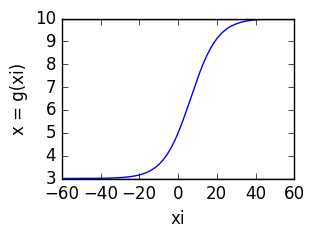

In [13]:
using PyPlot

function g(x, x0, x1)
    m = 0.5*(x0+x1)
    d = x1-x0
    
    return x0 + (x1-x0)./(1 + exp.(-(x-m)/d))
end

h = figure(1); clf(); h[:set_size_inches](3, 2); 
x0 = 3; x1 = 10; x = -60:0.1:60

plot(x, g(x, x0, x1), "-"); 

xlabel("xi"); ylabel("x = g(xi)"); hlines([x0, x1], xlim()[1], xlim()[2]); 

**Our strategy:**

Now here is our strategy: instead of minimizing the function $f(x)$ subject to the range constraints, we will instead  minimize the function $f(g(\xi))$ subject to *no* constraints on $\xi$. 

To start the minimization, if we wanted to start at $x = x_{seed}$, we first compute $\xi_{seed} = g^{-1}(x_{seed})$, and we start at that value of $\xi_{seed}$. That will correspond to having started at $x_{seed}$, as desired.

For every value of $\xi$ there is a corresponding value of $x = g(\xi)$. And no matter where $\xi$ ranges, its corresponding value of $x$ will be strictly bounded within the desired limits.  Note that 

$$
    \frac{{\rm d}f}{{\rm d}x} = \frac{{\rm d}f}{{\rm d}g} \cdot \frac{{\rm d}g}{{\rm d}\xi}
$$

Therefore, as $x$ approaches the rangle limits (which corresponds to $|\xi - m| >> d$), we will be approaching the flat part of $g()$ and therefore $\frac{{\rm d}g}{{\rm d}\xi}$ will approach zero and so will $\frac{{\rm d}f}{{\rm d}x}$: this is what prevents the search from going beyond the bounds. Note also that in each iteration of  bbox_hessian_keyword_minimization() we ask for the step that would minimize the cost function *given a certain step magnitude*. This means we will avoid directions that have little impact on the cost function.



**The helper functions are**:

* **pdict()** takes a dictionary of range limits, and a dictionary of current free range parameter values and returns a dictionary of the corresponding "walled" values, constrained to lie within the desired bounds. (I.e., puts values through tanh())
* **vector_wrap()** does the same as pdict, except that instead of the dictionary of current free range parameter values, it takes a list of strings and a corresponding vector of values, and returns a vector.
* **inverse_wall()** is the inverse of the above two operations: if passed a dictionary of ranges and a dictionary of constrained values, it returns a dictionary of the corresponding free range values. If passed a list of strings and a vector or the corresponding constrained values, returns a vector of the corresponding free-range, unconstrained values.

In [14]:
#@include_me hessian_utils.jl



"""
pdict = wallwrap(bdict, pdict)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, and pdict, a dictionary of symbols
to values (or, alternatively, an Array of (Symbol, value) tuples], goes through each of the symbols in 
bdict and modifies the corresponding value in pdict putting it through a tanh so the final output lies 
within the limits in bdict.  Returns the new pdict.  Makes a copy of pdict so as not to modify the original.
"""
function wallwrap(bdict, epdict)
    local pdict = two_level_copy(epdict)  # Must be very careful here! I got bit by the bug of forgetting that without
    # an explicit copy() call, Julia does not make copies of the contents of arrays or dictionaries, making it
    # easy to inadvertently modify something one did not intend to perturb.  Note the two_level_copy() call, 
    # necessary to make sure we don't mess up the content of the caller's dictionary.
    
    if typeof(pdict)<:Array
        pdict = Dict(pdict)
    end

    allkeys = keys(bdict)

    for k in allkeys
        local bbox = bdict[k]
        d = 0.5*(bbox[2] - bbox[1])
        m = 0.5*(bbox[2] + bbox[1])

        pdict[k] = bbox[1] + d*(tanh((pdict[k]-m)/d)+1)
    end
    return pdict
end

    
"""
params = vector_wrap(bbox, args, eparams)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, args, an array of strings representing
symbols, and params, an array of values corresponding to the args list, puts each param that has an entry 
in bdict through the tanh-walling mechanism, and returns the result. Does not modify the contents of the 
original params vector (or bdict or args).
"""
function vector_wrap(bbox, args, eparams)
    local params = two_level_copy(eparams)
    pdict = wallwrap(bbox, make_dict(args, params))
    i=1; j=1
    for i=1:length(args)
        if typeof(args[i])<:Array
            params[j:j+args[i][2]-1] = pdict[Symbol(args[i][1])]
            j += args[i][2]-1
        else
            params[j] = pdict[Symbol(args[i])]
        end
    j = j+1
    end
    return params
end


"""
params = inverse_wall(bdict, args, wparams)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, args, an array of strings representing
symbols, and wparams, an array of values corresponding to the args list where each param that has an entry 
in bdict has alreadt been through the tanh-walling mechanism, UNwalls the ones that have a bdict entry and
returns the result. Does not modify the contents of the original params vector (or bdict or args).
"""
function inverse_wall(bdict, args, wparams)
    local params = two_level_copy(wparams)
    pdict = inverse_wall(bdict, make_dict(args, params))
    i=1; j=1
    for i=1:length(args)
        if typeof(args[i])<:Array
            params[j:j+args[i][2]-1] = pdict[Symbol(args[i][1])]
            j += args[i][2]-1
        else
            params[j] = pdict[Symbol(args[i])]
        end
        j = j+1
    end
    return params    
end

    
"""
pdict = inverse_wall(bdict, wdict)
Given bdict, a dictionary of symbols to [minval, maxval] vectors, and wdict, a dictionary of symbols to values
(or vectors of values)  UNwalls the ones that have a bdict entry and
returns the result. Does not modify the contents of any dictionaries.
"""
function inverse_wall(bdict, wdict)
    local pdict = two_level_copy(wdict)

    allkeys = keys(bdict)
    for k in allkeys
        local bbox = bdict[k]
        d = 0.5*(bbox[2] - bbox[1])
        m = 0.5*(bbox[2] + bbox[1])

        pdict[k] = m + d*0.5*log((pdict[k]-bbox[1])./(2*d - pdict[k] + bbox[1]))
    end
    return(pdict)
end
  

inverse_wall

# The main bbox_hessian_keyword_minimization() function

Minimizes a scalar function $f()$ of keyword-value pairs, by searching for the parameter values that produce the smallest output. At each step of the minimization, uses ForwardDiff to compute the gradient $\bf g$ and the Hessian $H$ at the current set of parameter values ${\bf p_0}$; and then uses constrained_parabolic_minimization() to find the the parameter values ${\bf p}$, such that $|{\bf p} - {\bf p_0}| <= \eta$, that would minimize the parabolic approximation to the cost function

$$
J({\bf p}) = J({\bf p_o}) + {\bf g}^T ({\bf p} - {\bf p_0}) + \frac{1}{2} ({\bf p} - {\bf p_0})^T \cdot H \cdot ({\bf p} - {\bf p_0})
$$

If the cost $f({\bf p}) < f({\bf p_0})$, then the step is accepted, the current parameter values become ${\bf p}$ and $\eta$ is increased slightly. Otherwise the step is not accepted, current parameter values are not changed, and $\eta$ is cut by a factor of 2.  Note than when $\eta$ is very small, this becomes gradient descent. It is only when $\eta$ is larger that the Hessian begins to play a role.

A parameter step for which $|{\bf p} - {\bf p_0}| < \eta$ is called a "Newton" jump (it is Newton's method). A step in which $|{\bf p} - {\bf p_0}| = \eta$ is called a "constrained" jump. If the `verbose=true option` is selected, then the diagnostic information printed out at each step includes the cosine of the angle between the step taken and the gradient (when this is close to -1, we're doing gradient descent; far from -1, we're using the Hessian information).

**FAILURE MODES:**  At each step of the search iteration, constrained_parabolic_minimization(), which itself involves a search, may fail. For diagnostics on this, a matrix called `cpm_traj` is returned. Its first row is the number of iterations run by constrained_parabolic_minimization()'s internal search, at each step of the overall search. If this number is equal to the maximum requested (currently hardcoded as 500 iterations), that means that constrained_parabolic_minimization() returned only because it ran into its maximum iteration limit, not because it was successful, and is therefore a sign of a step that may have been taken in a poor direction.

**RETURNING MULTIPLE OUTPUTS IN $f()$:** In the implementation below, $f()$ must either return a scalar, or the first output it returns must be a scalar. That scalar is what will be minimized. The trajectory across the minimization of any further outputs that f() returns will be available in ftraj (see help documentation for `bbox_Hessian_keyword_minimization()` below). **Note that you might want to convert some of those outputs into
Float64s, so they don't return as ForwardDiff Duals.**  See example in the cell below.


In [15]:
#@include_me hessian_utils.jl


# Julia 0.5 returns an error if you run Pkg.installed on a package that has not been installed
try
    Pkg.installed("JLD")
catch
    Pkg.add("JLD")
end

# Julia 0.6 does not crash but returns a Void if you run Pkg.installed on a package that has not been installed
if isa(Pkg.installed("JLD"), Void)
    Pkg.add("JLD")
end


using JLD
using MAT


######################################################
#                                                    #
#         BBOX_HESSIAN_KEYWORD_MINIMIZATION          #
#                                                    #
######################################################




"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; start_eta=10, tol=1e-6, 
maxiter=400, verbose=false, report_file="")

Like constrained_Hessian_minimization, but uses keyword_hessian!(). 

# PARAMETERS:

- seed        column vector, representing the starting value of the parameters.

- args        List of strings identifying parameters for differentiation, e.g., ["const_E", "w_self]

- bbox        If softbox=true (the default), should then be a Dict of Symbol=>[minval maxval] entries. An entry
            in this Dict indicates that the corresponding parameter is to be bounded, as indicated by the associated 
            [minval maxval] vector. The bbox dictionary can have fewer entries than the number of parameters, and its
            default value is Dict(), indicating an unbounded search.
                If softbox=false, then bbox should be an nargs-by-2 matrix indicating the range for each argument,
            with the minima (first column) and maxima (second column), and entries for ALL parameters.

- func        func must take only optional keyword args, and must 
            take nderivs=0, difforder=0  and declare any new matrices using ForwardDiffZeros() instead of zeros().
            func must either return a scalar, or the first output it returns must be a scalar. 
            That scalar is what will be minimized. The trajectory across the minimization of 
            any further outputs that f() returns will be available in ftraj (see RETURNS below)


# OPTIONAL PARAMETERS:

- start_eta    Starting value of the radius.  It's good to start with somethibg biggish, if it is
             too much, it'll quickly get cut down.

- tol=1e-6     Numerical tolerance. If a proposed jump produces a change in func that is less than
             this, the minimization stops.

- maxiter=400  Maximum number of iterations to do before stopping

- verbose=false   If true, print out a report on each iteration of iteration number, radius size (eta),
                what type jump was proposed ("Newton" means going straight to global min, "constrained" means jump has 
                norm eta, failed means that finding the minimum at a given radius somehow didn't work). Will also
                print out the cosine of the angle between the proposed jump and the gradient.

- verbose_level   If less than 2, regular verbose output, if 2 or greater, very verbose, for debugging.

- softbox       If true, then bbox must be a Dict() and we use the tanh() mechanism for putting a fixed limit
                on the parameters. NO LONGER SUPPORTING ANYTHING OTHER THAN softbox=true (which is the default)

- report_file   If non-empty, at each iteration timestep will write into this file outputs trajectory, 
                (which contains eta, cost, and parameters), cpm_traj, and ftraj (which contains gradient, hessian, 
                and further cost function outputs).  The file must be a JLD file, and so will end with a .jld extension.
                To load the saved dictionary, simply do D = load(filename)  (we have already called "using JLD" for you.)



# RETURNS:

- params       A vector the size of seed that has the last values of the minimizing parameters for func
- trajectory   A (2+length(params))-by-nsteps matrix. Each column corresponds to an iteration step, and contains
                 the value of eta used, the cost, and the value of the parameters at that iteration
- cost         Final value of objective function
- cpm_traj     A 2-by-nsteps matrix, containing reports from the contrained parabolic minimization at each timestep.
             The first row is niters (how many iterations cpm's 1-d minimization ran for) and the second row is
             Dlambda, the last change in the parameter being minimized in cpm's internal search
- ftraj     Further components for the trajectory, will be an Array{Any}(3, nsteps). First row is gradient,
            second row is Hessian, third row is second-and-further outputs of func, each one at each step of
            the minimization. **NOTE** that if these further outputs contain variables that are being minimized, 
            they'll come out as ForwardDiff Duals, which you might not want!  So, for example, you might want to
            convert vectors and matrices into Float64s before returning them in those extra outputs. E.g.,
            if you want to return sum(err.*err) as the scalar to be minimized, and also return err, in your 
            cost function you would write   " return sum(err.*err), Array{Float64}(err) ".   That way the first,
            scalar output can still be differentiated, for minimization, and the second one comes out in readable form.



# EXAMPLE:  (see also a more complete example in Cost Function Minimization and Hessian Utilities.ipynb)

```
function tester(;x=5, y=10, z=20, nderivs=0, difforder=0)
    return x^2*y + z/tanh(y)
end

params, trajectory = bbox_Hessian_keyword_minimization([0.5, 0.5], ["x", "y"], [1.1 2 ; 1.1 4], tester, 
    verbose=true, tol=1e-12, start_eta=1);
```


"""
function bbox_Hessian_keyword_minimization(seed, args, bbox, func; start_eta=0.1, tol=1e-6, maxiter=400,
    verbose=false, verbose_level=1, verbose_every=1, softbox=true, hardbox=false, report_file="")

    # --- check that saving will be done to a .jld file ---
    if length(report_file)>0 && splitext(report_file)[2] != ".jld"
        if splitext(report_file)[2] == ""
            report_file = resport_file * ".jld"
        else
            error("Sorry, report_file can only write to JLD files, the extension has to be .jld")
        end
    end

    
    # --------- Initializing the trajectory trace and function wrapper--------
 
    traj_increment = 100
    params = 0  # Make sure to have this here so that params stays defined beyond the try/catch
    if ( !(typeof(bbox)<:Dict) ); error("Currently only supporting softbox=true, bbox must be a Dict"); end;
    try
        params = copy(inverse_wall(bbox, args, seed))
    catch
        error("Were all initial param values within the indicated walls?")
    end
    eta = start_eta
    trajectory = zeros(2+length(params), traj_increment); cpm_traj = zeros(2, traj_increment)
    
    ftraj = Array{Any}(3,0)  # will hold gradient, hessian, and further_out,  per iteration

    further_out =[];  # We define this variable here so it will be available for stashing further outputs from func
    
    # Now we define a wrapper around func() to do three things: (a) wallwrap parameters using the softbox method;
    # (b) return as the desired scalar the first output of func; (c) stash in further_out any further outputs of func
    internal_func = (;pars...) -> begin
        fresults = func(;wallwrap(bbox, pars)...)   # note use of bbox external to this begin...end
        if typeof(fresults)<:Tuple
            answer = fresults[1]
            further_out = fresults[2:end]
        else
            answer = fresults
        end
        return answer  # we assume that the first output of func() will always be a scalar, and that's what we return for ForwardDiff
    end

    # --------- END Initializing the trajectory trace --------

    if verbose
        @printf "%d: eta=%g ps=" 0 eta 
        print_vector(vector_wrap(bbox, args, params))
        @printf "\n"
    end
    
    if softbox
        if !(typeof(bbox)<:Dict); error("bhm: If softbox=true, then bbox must eb a Dict"); end
        cost, grad, hess = keyword_vgh(internal_func, args, params)  # further_out will be mutated
    elseif hardbox
        error("Sorry, no longer supporting hardbox=true")
    else
        error("Sorry, no longer supporting softbox=false")
    end
        
    chessdelta = zeros(size(params))
    
    i=0  # here so variable i is available outside the loop
    for i in [1:maxiter;]
        if i > size(trajectory, 2)
            trajectory = [trajectory zeros(2+length(params), traj_increment)]
            cpm_traj   = [cpm_traj   zeros(2, traj_increment)]
        end
        trajectory[1:2, i]   = [eta;cost]
        trajectory[3:end, i] = vector_wrap(bbox, args, params)
        ftraj = [ftraj [grad, hess, further_out]]

        if length(report_file)>0
            save(report_file, Dict("traj"=>trajectory[:,1:i], "cpm_traj"=>cpm_traj[:,1:i], "ftraj"=>ftraj))
        end
        
        hessdelta  = - inv(hess)*grad
        try
            if verbose && verbose_level >= 2
                @printf("bhm: about to try cpm with grad : "); print_vector_g(grad); print("\n")
                @printf("bhm:   hess :"); print_vector_g(hess[:]); print("\n");
            end
            if verbose && verbose_level >= 2
                cpm_out = constrained_parabolic_minimization(hess, grad'', eta, 
                    maxiter=500, tol=1e-20, do_plot=true, verbose=true)                
            else
                cpm_out = constrained_parabolic_minimization(hess, grad'', eta, maxiter=500, tol=1e-20)
            end
            chessdelta = cpm_out[1]; cpm_traj[1,i] = cpm_out[5]; cpm_traj[2,i] = cpm_out[6]
            jumptype = "not failed"
        catch y
            jumptype = "failed"
            if verbose
                @printf "Constrained parabolic minimization failed with error %s\n" y
                @printf "\n"
                @printf "eta was %g\n" eta
                @printf "grad was\n"
                print_vector(grad)
                @printf "\n\nhess was\n"
                for k in [1:length(grad);]
                    print_vector(hess[k,:])
                    @printf "\n"
                end
                @printf "\n"
                matwrite("error_report.mat", Dict("grad"=>grad, "hess"=>hess, "eta"=>eta))
            end
            break
        end

        if norm(hessdelta) <= eta
            new_params = params + hessdelta
            jumptype = "Newton"
        elseif jumptype != "failed" 
            new_params = params + chessdelta
            jumptype  = "constrained"
        end

        if jumptype != "failed"
            new_cost, new_grad, new_hess = keyword_vgh(internal_func, args, new_params)   # further_out may mutate
            if verbose && verbose_level >=2
                @printf("bhm: had new_params = : "); print_vector_g(vector_wrap(bbox, args, params)); print("\n");
                @printf("bhm: and my bbox was : "); print(bbox); print("\n")
                @printf("bhm: and my wallwrap output was : "); print(wallwrap(bbox, make_dict(args, new_params))); print("\n")
                @printf("bhm: and this produced new_grad : "); print_vector_g(new_grad); print("\n")
                @printf("bhm:   new_hess :"); print_vector_g(new_hess[:]); print("\n");                                        
            end
            
            if abs(new_cost - cost) < tol || eta < tol
                if verbose
                    @printf("About to break -- tol=%g, new_cost-cost=%g, eta=%g\n", tol, new_cost-cost, eta)
                end
                break
            end
        end

        if jumptype == "failed" || new_cost >= cost  
            if verbose
                @printf("eta going down: new_cost-cost=%g and jumptype='%s'\n", new_cost-cost, jumptype)
                if verbose_level >= 2
                    nwp = vector_wrap(bbox, args, new_params); wp = vector_wrap(bbox, args, params)
                    @printf("   vvv: proposed new params were : "); print_vector_g(nwp); print("\n")
                    @printf("   vvv: proposed delta params was : "); print_vector_g(nwp-wp); print("\n")
                    @printf("   vvv: grad was : "); print_vector_g(grad); print("\n")
                    costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))
                    @printf("   vvv: costheta of proposed jump was %g\n", costheta)
                end
            end
            eta = eta/2
            costheta = NaN
            if eta < tol
                if verbose
                    @printf("About to break -- tol=%g, new_cost-cost=%g, eta=%g\n", tol, new_cost-cost, eta)
                end
                break
            end
        else
            eta = eta*1.1
            costheta = dot(new_params-params, grad)/(norm(new_params-params)*norm(grad))

            params = new_params
            cost = new_cost
            grad = new_grad
            hess = new_hess
        end

        if verbose
            if rem(i, verbose_every)==0
                @printf "%d: eta=%g cost=%g jtype=%s costheta=%.3f ps=" i eta cost jumptype costheta
                print_vector_g(vector_wrap(bbox, args, params))
                @printf "\n"
                if verbose_level >= 3
                    @printf "    At this point, grad is ="
                    print_vector_g(grad)
                    @printf "\n"                
                end
            end
        end
    end

    trajectory = trajectory[:,1:i]; cpm_traj = cpm_traj[:,1:i]
    if length(report_file)>0
        save(report_file, Dict("traj"=>trajectory, "cpm_traj"=>cpm_traj, "ftraj"=>ftraj))
    end
    
    return vector_wrap(bbox, args, params), trajectory, cost, cpm_traj, ftraj
end

bbox_Hessian_keyword_minimization

## Basic example of using bbox_Hessian_keyword_minimization()

We'll fit a sigmoid to some data generated from a sigmoid with noise.

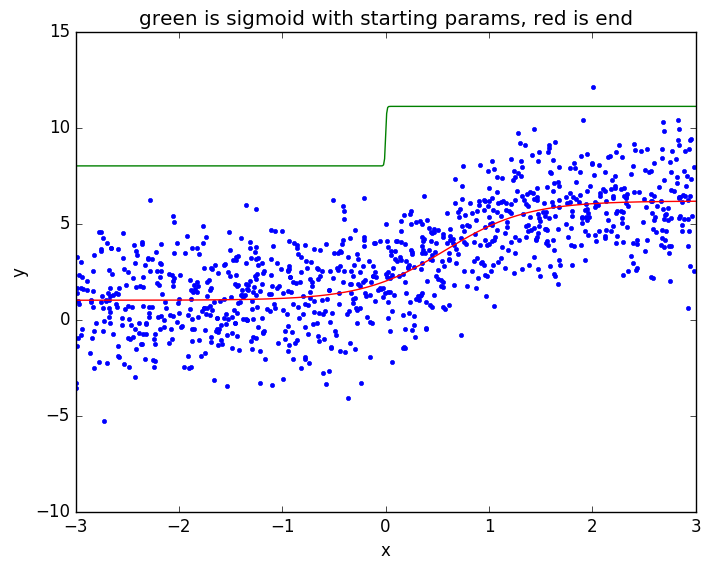

PyObject <matplotlib.text.Text object at 0x147963278>

In [16]:
pygui(false)

npoints = 1000; # srand(400)
args = ["baseline", "amplitude", "threshold", "slope"]

# Generating values for our four params:
params = [1 5 0.5 0.8]

# Make some points and plot them
x = rand(npoints, 1)*6-3
y = params[1] + params[2]*0.5*(tanh.((x-params[3])/params[4])+1) + randn(npoints,1)*2
figure(1); clf();
plot(x, y, ".")

# Starting values for the four params. Plot the corresponding curve they generate
seed = [8, 3.1, 0, 0.01]
xx = -3:0.01:3
plot(xx, seed[1] + seed[2]*0.5*(tanh.((xx-seed[3])/seed[4])+1), "g-")

if FDversion() < 0.6
    # If using ForwardDiff version < 0.6  (e.g., with Julia 0.5.2) --------
    #
    # Cost function.  Note that it takes nderivs and difforder as parameters. First output is the scalar
    # that will be minimized, and we also returns a second output whose trajectory will be stashed 
    # by bbox in ftraj as a diagnostic during the minimization.
    function JJ(x, y; baseline=0, amplitude=1, threshold=0, slope=1, do_plot=false, fignum=1, clearfig=true,
        nderivs=0, difforder=0)

        if do_plot
            figure(fignum);
            if clearfig; clf(); end;
            xx = -3:0.01:3; x2=ForwardDiffZeros(size(xx,1), size(xx,2), nderivs=nderivs, difforder=difforder)
            for i=1:length(xx); x2[i]=xx[i]; end; xx= x2

            plot(x, y, ".")
            plot(xx, baseline + amplitude*0.5*(tanh((xx-threshold)/slope)+1), "r-")
        end

        yhat =  baseline + amplitude*0.5*(tanh((x-threshold)/slope)+1) 
        err = yhat - y
        return sum(err.*err), Array{Float64}(err)    # Note first output, the scalar to be minimized,
        # may be ForwardDiff Duals during the minimization, which is fine, so it can be differentiated.
        # The second one we cast into regular Float64 so it comes out readable.
    end
else 
    # If using ForwardDiff version >= 0.6  (e.g., with Julia 0.6) --------
    #
    # Cost function.  Note that it takes nderivs and difforder as parameters. First output is the scalar
    # that will be minimized, and we also returns a second output whose trajectory will be stashed 
    # by bbox in ftraj as a diagnostic during the minimization.
    function JJ(x, y; baseline=0, amplitude=1, threshold=0, slope=1, do_plot=false, fignum=1, clearfig=true)

        if do_plot
            figure(fignum);
            if clearfig; clf(); end;
            xx = -3:0.01:3; x2=zeros(get_eltype((baseline,amplitude,threshold,slope)), size(xx,1), size(xx,2))
            for i=1:length(xx); x2[i]=xx[i]; end; xx= x2

            plot(x, y, ".")
            plot(xx, baseline + amplitude*0.5*(tanh.((xx-threshold)/slope)+1), "r-")
        end

        yhat =  baseline + amplitude*0.5*(tanh.((x-threshold)/slope)+1) 
        err = yhat - y
        return sum(err.*err), get_value(err)    # Note first output, the scalar to be minimized,
        # may be ForwardDiff Duals during the minimization, which is fine, so it can be differentiated.
        # The second one we use get_value to turn into regular Float64 array so it comes out readable.
    end

end


if ~isdir("Trash"); mkdir("Trash"); end;  # we're going to put the iteration-step by iteration-step report file there

bbox = Dict(:baseline=>[-2, 10], :slope=>[0.001 5])
func = (;pars...) -> JJ(x, y; do_plot=false, pars...)

opars, traj, cost, cpm_traj, ftraj = bbox_Hessian_keyword_minimization(seed, args, bbox, func,
verbose=false, verbose_level=1, softbox=true, start_eta=1, report_file="Trash/example_report.jld")

# Note that the gradient at step i of the minimization will be available as ftraj[1,i], the hessian will be 
# in ftraj[2,i], and the error vector, which is the first of the extra outputs of JJ(), will be in ftraj[3,i][1].
# In our example JJ() produced only one extra output; a second extra output would be in ftraj[3,i][2], and so on.

# Plot the resulting curve, and report both final and generating params
plot(xx, opars[1] + opars[2]*0.5*(tanh.((xx-opars[3])/opars[4])+1), "r-")
[opars' ; params]
xlabel("x"); ylabel("y"); title("green is sigmoid with starting params, red is end")




In [ ]:
err = ftraj[3,1][1]
